In [1]:
# imports
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

2023-05-19 15:19:10.310351: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 15:19:10.787064: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 15:19:10.789139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 15:19:13.653396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = np.load('../data/npy/channel_flow.npy')

# init model & load data
data_path = '../data/npy/channel_flow.npy'
model_path = '../model/fluid/'
result_path = '../result/fluid/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=4)

In [3]:
phi_tot = tf.expand_dims(data, axis=3)
new_phi = phi_tot[:490]
print(np.shape(new_phi))
phi_test = phi_tot[490:]

2023-05-19 15:19:26.076727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 15:19:26.078376: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-19 15:19:26.096100: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 129794000 exceeds 10% of free system memory.


(490, 511, 127, 1)


2023-05-19 15:19:26.478091: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 127198120 exceeds 10% of free system memory.


In [4]:

# NN

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=500,
  decay_rate=0.5,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Nadam()


def compile_and_fit(model, name, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError() ,
                metrics=[tf.keras.losses.MeanAbsoluteError()]),
                

    model.summary()

    history = model.fit(
            new_phi, new_phi,
            #steps_per_epoch = STEPS_PER_EPOCH,
            epochs=500,
            validation_split=0.1,
            callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20),
            verbose=2)

    return history



In [5]:

y = tf.keras.layers.AveragePooling2D(pool_size=(3, 3),
   padding='valid')(new_phi)
#y = tf.keras.layers.Conv2D(2, 3, padding= 'valid',activation='linear', input_shape=(127,127,))(new_phi)
print(tf.shape(y))

tf.Tensor([490 170  42   1], shape=(4,), dtype=int32)


In [8]:


NN1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(256,64,)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Reshape((256, 64, 1)),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
NN2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(1, 5),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
# inputs      = tf.keras.Input(shape=(3,))
# outputs     = dense(inputs)
# Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

inputs      = tf.keras.Input(shape=(new_phi.shape[1:]))
#outputs     = inputs[:,0:3] + 0.01*dense(inputs)
#upscaling davanti a NN1
outputs     = NN1(tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(inputs)) + NN2(inputs)
Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

history = compile_and_fit(Updatemodel, 'Lorentz')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 511, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 256, 64, 1)  0           ['input_2[0][0]']                
 oling2D)                                                                                         
                                                                                                  
 sequential_2 (Sequential)      (None, 511, 127, 1)  2400        ['average_pooling2d_2[0][0]']    
                                                                                            

2023-05-19 15:21:25.585119: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 114478308 exceeds 10% of free system memory.


Epoch 1/500


: 

: 

In [ ]:
test_true = phi_test
test_model = history.model.predict(phi_test)

NameError: name 'history' is not defined

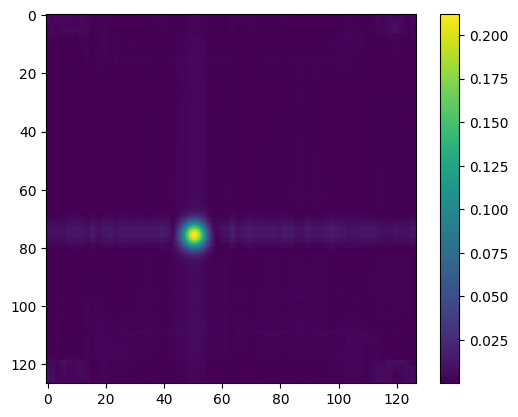

In [ ]:
plt.imshow(np.abs(test_true[-1]-test_model[-1]))
plt.colorbar()

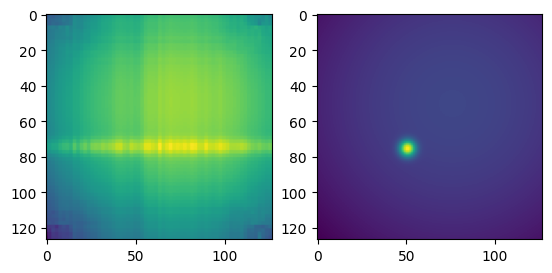

In [ ]:
ind = -1
fig,axs = plt.subplots(1,2,figsize=(8,8))
im = axs[0].imshow(test_true[ind])
axs[0].set_title('true')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(test_model[ind])
axs[1].set_title('reconstruction')
plt.colorbar(im, ax=axs[1])

In [ ]:
print(test_model[-1])

[[[0.64086944]
  [0.64530736]
  [0.64530736]
  ...
  [0.6647346 ]
  [0.65677357]
  [0.65677357]]

 [[0.64452034]
  [0.64997673]
  [0.64997673]
  ...
  [0.6683426 ]
  [0.6634307 ]
  [0.6634307 ]]

 [[0.64452034]
  [0.64997673]
  [0.64997673]
  ...
  [0.6683426 ]
  [0.6634307 ]
  [0.6634307 ]]

 ...

 [[0.6277203 ]
  [0.6337718 ]
  [0.6337718 ]
  ...
  [0.65027726]
  [0.6486408 ]
  [0.6486408 ]]

 [[0.62424284]
  [0.6330909 ]
  [0.6330909 ]
  ...
  [0.64871883]
  [0.64598536]
  [0.64598536]]

 [[0.62424284]
  [0.6330909 ]
  [0.6330909 ]
  ...
  [0.64871883]
  [0.64598536]
  [0.64598536]]]
